# Fuzzy Logics

**Author: Brian van den Berg**

In [355]:
import sys
from datetime import date
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib
import matplotlib.pyplot as plt

# Print the version register
print(f'Version register as of {date.today()}:')
print(f'python3: {sys.version}')
print(f'numpy: {np.__version__}')
print(f'skfuzzy: {fuzz.__version__}')
print(f'matplotlib: {matplotlib.__version__}')

Version register as of 2023-12-15:
python3: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
numpy: 1.26.2
skfuzzy: 0.4.2
matplotlib: 3.8.2


## Linguistic Variables

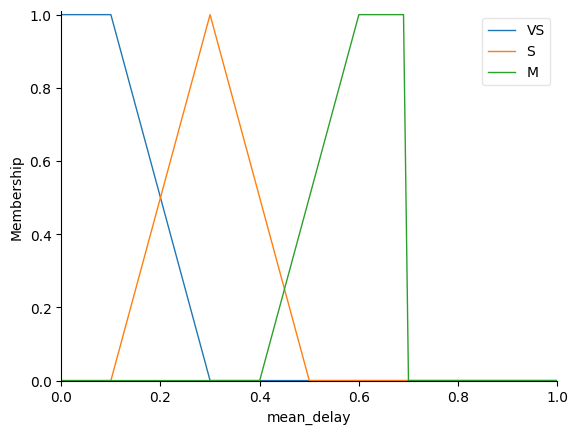

In [356]:
# Define the universe (linespace)
universe = np.arange(0.00, 1.01, 0.01)

# Mean delay Antecedent
m = ctrl.Antecedent(universe, 'mean_delay')
m['VS'] = fuzz.trapmf(m.universe, [0.0, 0.0, 0.1, 0.3])
m['S'] = fuzz.trimf(m.universe, [0.1, 0.3, 0.5])
m['M'] = fuzz.trapmf(m.universe, [0.4, 0.6, 0.7, 0.7])

# Display the Mean delay Membership Functions
m.view()

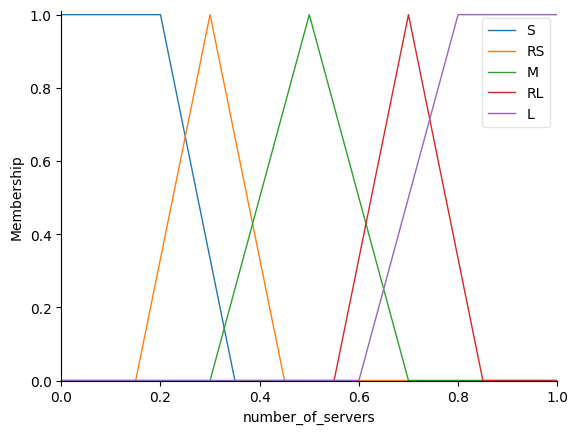

In [357]:
# Number of servers Antecedent
s = ctrl.Antecedent(universe, 'number_of_servers')
s['S'] = fuzz.trapmf(s.universe, [0.0, 0.0, 0.2, 0.35])
s['RS'] = fuzz.trimf(s.universe, [0.15, 0.3, 0.45])
s['M'] = fuzz.trimf(s.universe, [0.3, 0.5, 0.7])
s['RL'] = fuzz.trimf(s.universe, [0.55, 0.7, 0.85])
s['L'] = fuzz.trapmf(s.universe, [0.6, 0.8, 1.0, 1.0])

# Display the Number of servers Membership Functions
s.view()

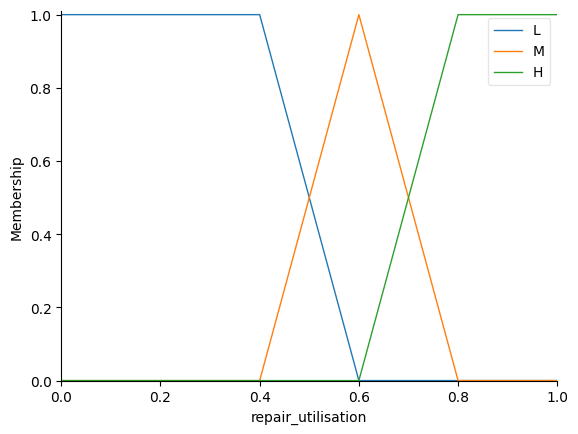

In [358]:
# Repair utilisation factor Antecedent
p = ctrl.Antecedent(universe, 'repair_utilisation')
p['L'] = fuzz.trapmf(p.universe, [0.0, 0.0, 0.4, 0.6])
p['M'] = fuzz.trimf(p.universe, [0.4, 0.6, 0.8])
p['H'] = fuzz.trapmf(p.universe, [0.6, 0.8, 1.0, 1.0])

# Display the Repair utilisation factor Membership Functions
p.view()

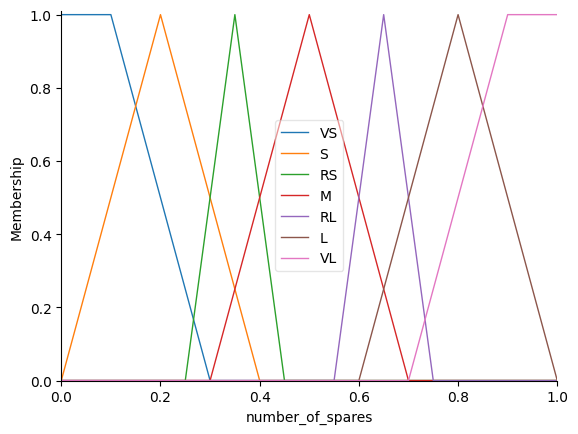

In [359]:
# Number of spares Consequent
n = ctrl.Consequent(universe, 'number_of_spares')
n['VS'] = fuzz.trapmf(n.universe, [0.0, 0.0, 0.1, 0.3])
n['S'] = fuzz.trimf(n.universe, [0.0, 0.2, 0.4])
n['RS'] = fuzz.trimf(n.universe, [0.25, 0.35, 0.45])
n['M'] = fuzz.trimf(n.universe, [0.3, 0.5, 0.7])
n['RL'] = fuzz.trimf(n.universe, [0.55, 0.65, 0.75])
n['L'] = fuzz.trimf(n.universe, [0.6, 0.8, 1.0])
n['VL'] = fuzz.trapmf(n.universe, [0.7, 0.9, 1.0, 1.0])

# Display the Number of spares Membership Functions
n.view()

## Rules

In [360]:
# Fuzzy System Rules
system_rules = [
    ctrl.Rule(antecedent=((s['S'] | s['RS'] | s['M']) & p['L']),                consequent=n['VS']),
    ctrl.Rule(antecedent=((m['VS'] | m['S']) & (s['RL'] | s['L']) & p['L']),    consequent=n['S']),
    ctrl.Rule(antecedent=(m['M'] & (s['RL'] | s['L']) & p['L']),                consequent=n['VS']),
    ctrl.Rule(antecedent=(m['VS'] & (s['S'] | s['RS']) & p['M']),               consequent=n['S']),
    ctrl.Rule(antecedent=((m['S'] | m['M']) & (s['S'] | s['RS']) & p['M']),     consequent=n['VS']),
    ctrl.Rule(antecedent=(m['VS'] & s['M'] & p['M']),                           consequent=n['RS']),
    ctrl.Rule(antecedent=(m['S'] & s['M'] & p['M']),                            consequent=n['S']),
    ctrl.Rule(antecedent=(m['M'] & s['M'] & p['M']),                            consequent=n['VS']),
    ctrl.Rule(antecedent=(m['VS'] & (s['RL'] | s['L']) & p['M']),               consequent=n['M']),
    ctrl.Rule(antecedent=(m['S'] & (s['RL'] | s['L']) & p['M']),                consequent=n['RS']),
    ctrl.Rule(antecedent=(m['M'] & (s['RL'] | s['L']) & p['M']),                consequent=n['S']),
    ctrl.Rule(antecedent=(m['VS'] & (s['S'] | s['RS']) & p['H']),               consequent=n['VL']),
    ctrl.Rule(antecedent=(m['S'] & s['S'] & p['H']),                            consequent=n['L']),
    ctrl.Rule(antecedent=(m['M'] & s['S'] & p['H']),                            consequent=n['M']),
    ctrl.Rule(antecedent=(m['S'] & s['RS'] & p['H']),                           consequent=n['RL']),
    ctrl.Rule(antecedent=(m['M'] & s['RS'] & p['H']),                           consequent=n['RS']),
    ctrl.Rule(antecedent=(m['VS'] & s['M'] & p['H']),                           consequent=n['M']),
    ctrl.Rule(antecedent=(m['S'] & (s['M'] | s['RL'] | s['L']) & p['H']),       consequent=n['M']),
    ctrl.Rule(antecedent=(m['M'] & s['M'] & p['H']),                            consequent=n['S']),
    ctrl.Rule(antecedent=(m['VS'] & s['RL'] & p['H']),                          consequent=n['RL']),
    ctrl.Rule(antecedent=(m['M'] & (s['RL'] | s['L']) & p['H']),                consequent=n['RS']),
    ctrl.Rule(antecedent=(m['VS'] & s['L'] & p['H']),                           consequent=n['L']),
]

# Control system
spares_ctrl = ctrl.ControlSystem(system_rules)
sim = ctrl.ControlSystemSimulation(spares_ctrl)

## Usage of the System

Number of Spares: 0.47080338424678075


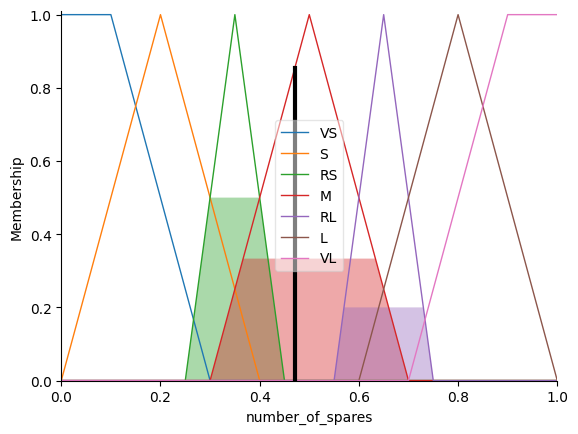

In [361]:
# Input values
sim.input['mean_delay'] = 0.03
sim.input['number_of_servers'] = 0.60
sim.input['repair_utilisation'] = 0.64

# Compute the fuzzy output
sim.compute()

# Print the output
print("Number of Spares:", sim.output['number_of_spares'])

# Visualize the output variable
n.view(sim=sim)
plt.show()

## Showcase of the Control Space

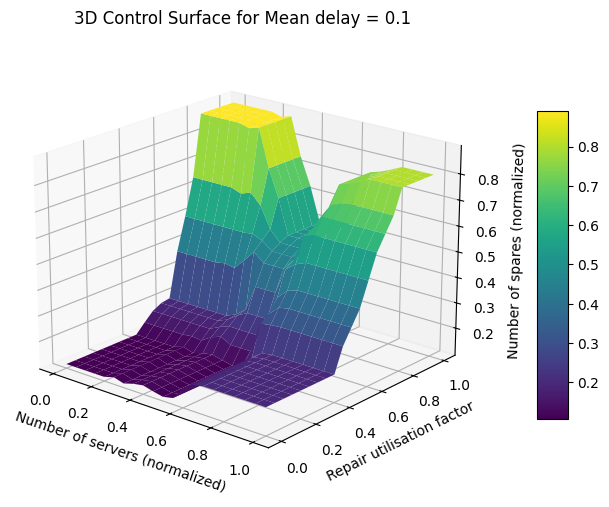

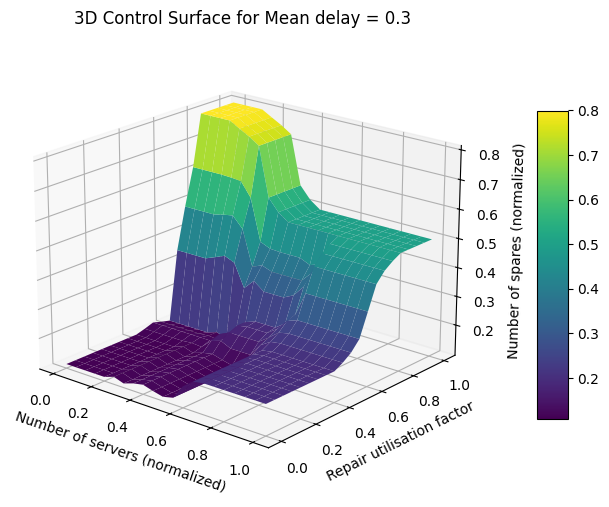

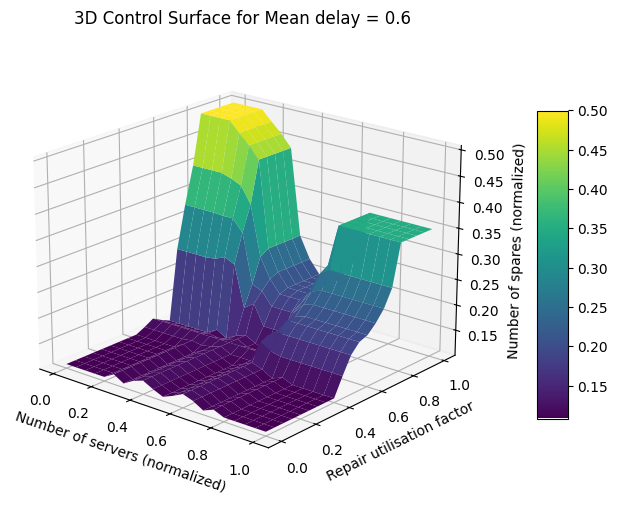

In [364]:
# Set the Mean delay values to visualize
mean_delay_values = [0.1, 0.3, 0.6]

# Plot for each Mean delay value
for mean_delay_value in mean_delay_values:
    # We can simulate at higher resolution with full accuracy
    no_samples = 21
    upsampled = np.linspace(0.0, 1.0, no_samples)
    x, y = np.meshgrid(upsampled, upsampled)
    z = np.zeros_like(x)

    # Loop through the system to collect the control surface
    for i in range(no_samples):
        for j in range(no_samples):
            sim.input['mean_delay'] = mean_delay_value
            sim.input['number_of_servers'] = x[i, j]
            sim.input['repair_utilisation'] = y[i, j]
            sim.compute()
            z[i, j] = sim.output['number_of_spares']

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='viridis',
                           linewidth=0.4, antialiased=True)

    cset = ax.contourf(x, y, z, zdir='z', offset=-2.5, cmap='viridis', alpha=0.5)
    cset = ax.contourf(x, y, z, zdir='x', offset=3, cmap='viridis', alpha=0.5)
    cset = ax.contourf(x, y, z, zdir='y', offset=3, cmap='viridis', alpha=0.5)

    # Add labels to the axes
    ax.set_xlabel('Number of servers (normalized)')
    ax.set_ylabel('Repair utilisation factor')
    ax.set_zlabel('Number of spares (normalized)')

    # Add a colorbar
    fig.colorbar(surf, ax=ax, pad=0.1, shrink=0.5, aspect=10)

    # Zoom out a bit
    ax.view_init(elev=20, azim=-50)

    # Add a title
    ax.set_title(f'3D Control Surface for Mean delay = {mean_delay_value}')
    plt.show()